# Introduction

One of the main aspects of a data scientist's work involves exploratory data analysis and data cleaning. To exercise this skill, I utilized a dataset wich provides data of the date of purchase, house age, location, distance to the nearest MRT station, and house price per unit area in Taiwan.

In [3]:
#import folium
import pandas as pd
import numpy as np
#import seaborn as sb
import matplotlib.pyplot as plt
#from IPython.display import display

In [18]:
dataframe = pd.read_csv("../database/real_estate.csv")
dataframe.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


# Data Cleaning
Before carrying out an profund analysis, it is necessary to clean the data.
On this step, some columns will be droped since it won't be use and others will be renamed for a better understanding of the data.

In [19]:
dataframe.drop(columns=["No", "X1 transaction date"], inplace=True)
dataframe.rename(columns={"X2 house age": "house_age", "X3 distance to the nearest MRT station": "dist_nearest_mrt_station", 
                          "X4 number of convenience stores": "num_convenience_stores", "X5 latitude": "latitude", "X6 longitude": "longitude",
                            "Y house price of unit area": "house_price_unit_area"}, inplace=True)

For a better understand of the data distribuition, the common metrics will be evaluated

In [23]:
dataframe.describe()

,house_age,nearest_mrt_station,num_convenience_stores,latitude,longitude,house_price_unit_area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


The data sems to be very clear and ready for use.

# Exploratory Data Analysis
For an initial analysis, we will seek to understand how our data would be organized spatially (according to latitude and longitude)

<Axes: xlabel='longitude', ylabel='latitude'>

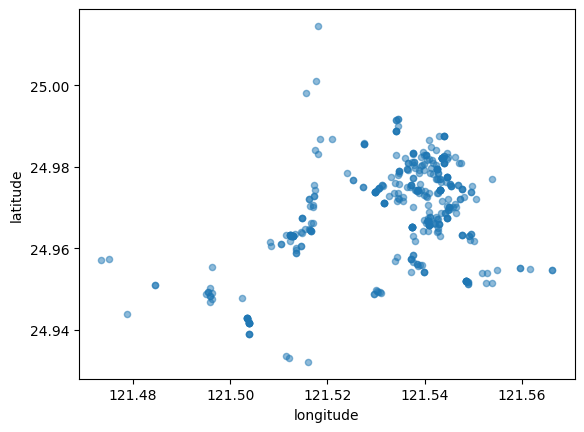

In [26]:
dataframe.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5)

With the purpose of gain some insight's it will be plot a longitude x latitude graph with color variation according to house price

<Axes: xlabel='longitude', ylabel='latitude'>

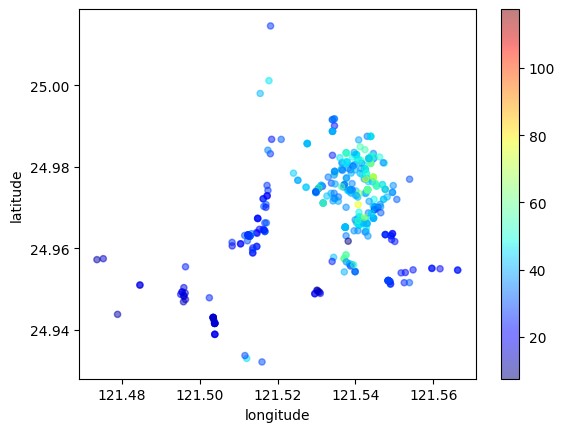

In [27]:
dataframe.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, c=dataframe["house_price_unit_area"], cmap=plt.get_cmap('jet'))

As a result, it can be seen that there is a interest variation in prices according to location. More expensive houses seems to be located more on the northwest side.

Let's investigate further.

In [28]:
correlation = dataframe.corr()
correlation["house_price_unit_area"].sort_values(ascending=False)

house_price_unit_area     1.000000
num_convenience_stores    0.571005
latitude                  0.546307
longitude                 0.523287
house_age                -0.210567
nearest_mrt_station      -0.673613
Name: house_price_unit_area, dtype: float64

It can be seen in the table above that there is a significant correlation between the price and the distance to the nearest metro station where when the value of the distance to the nearest metro station decrease, the house prince of unit area increase. 

Beside that, there is a moderate correlation between the number of convenience stores and the house price.

# Simple Linear Regression

Now that the data already was studied and understand, a machine learning model will be implemented to try predict the house prices based on one feature, distance to the nearest metro station. For this, it will be use a simple linear regression algorithm.

## Training Set

It is necessary to separate a training set and a test set. The training set should be use to train the learning algorithm and the test set will be for test if the algorithm is perfoming as it should.

In [ ]:
x_train = dataframe['dist_nearest_mrt_station']
y_train = dataframe['house_price_unit_area']

Since the main goal is to build a simple linear regression model to fit this data. A first step on this is to define a cost function. This function tells us how well the model is performing so that we can try to improve it. Essentially, this cost function calculates the difference, known as the error, between ŷ (the predicted value) and y (the actual target value). 
 
For a linear regression with one variable, the prediction of the model will be a linear function.

In [ ]:
def cost_function(x: pd.Series, y: pd.Series, w: float, b: float) -> float:
    number_of_samples = len(x)

    total_cost = 0
    sum_cost = 0

    for i in range(number_of_samples):
        f = (w*x[i]) + b
        current_cost = (f - y[i])**2

        sum_cost += current_cost
    
    total_cost = sum_cost(2*number_of_samples)

    return total_cost

It is important test if the code works. 

In [ ]:
initial_w = 2
initial_b = 1

cost = cost_function(x_train, y_train, initial_w, initial_b)
print(type(cost))
print(f'Cost at initial w: {cost:.3f}')